The Pavia University scene is a hyperspectral dataset collected by the ROSIS, over an agricultural area in Pavia, Italy. It is commonly used to categorize land cover and remote sensing research. The dataset consists of 610 rows and 340 columns, with 103 spectral bands altogether. Each pixel in the dataset represents a 1.3x1.3-meter area on the ground. The Pavia University scene dataset contains nine different classes of land cover, including various types of crops, bare soil, and meadows.  The dataset also includes ground truth maps that indicate the true class labels for each pixel in the image.
| No.  | Class                  | Samples |
|------|------------------------|---------|
| 1.   | Asphalt                | 6631    |
| 2.   | Meadows                | 18649   |
| 3.   | Gravel                 | 2099    |
| 4.   | Trees                  | 3064    |
| 5.   | Painted metal sheets   | 1345    |
| 6.   | Bare Soil              | 5029    |
| 7.   | Bitumen                | 1330    |
| 8.   | Self-Blocking Bricks   | 3682    |
| 9.   | Shadows                | 947     |




In [125]:
#imports
import urllib.request
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import earthpy.plot as ep
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
import plotly.graph_objects as go
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.models import Model


# Ignore all warnings
warnings.filterwarnings("ignore")


### Download The Pavia University Dataset

In [126]:

# Download PaviaU.mat
#urllib.request.urlretrieve("https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat", "PaviaU.mat")

# Download PaviaU_gt.mat
#urllib.request.urlretrieve("https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat", "PaviaU_gt.mat")


**PaviaU.mat** - The data set in .mat format

**PaviaU_gt.mat** - The ground truth of the dataset in .mat format

### Load the Data

In [127]:
# Load the .mat files
data = loadmat('PaviaU.mat')['paviaU']
gt = loadmat('PaviaU_gt.mat')['paviaU_gt']


In [128]:
#The dimensions of the data.
print(f'Dataset: {data.shape}\nGround Truth: {gt.shape}')

Dataset: (610, 340, 103)
Ground Truth: (610, 340)


### Visualize the image


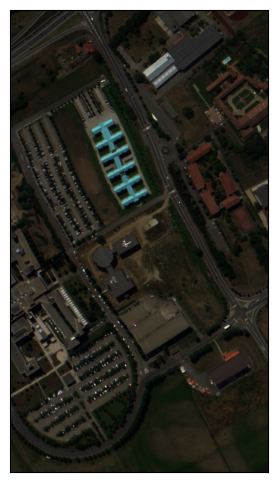

In [129]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(arr = mdata, rgb = (52, 30, 10),figsize=(6,6)) # Plotting the RGB image

plt.show()

### Visualize some random bands

In [130]:
def plot_band(dataset):
    #plot a 2*2 grid of random bands from the dataset with a colorbar 
    fig, axs = plt.subplots(2, 2, figsize=(7, 5))
    for i in range(2):
        for j in range(2):
            band = np.random.randint(0, dataset.shape[2])
            axs[i, j].imshow(dataset[:, :, band], cmap='nipy_spectral')
            axs[i, j].set_title(f'Band {band}')
            axs[i, j].axis('off')
    plt.colorbar(axs[1, 1].imshow(dataset[:, :, band], cmap='nipy_spectral'), ax=axs, orientation='vertical')
    plt.show()
    

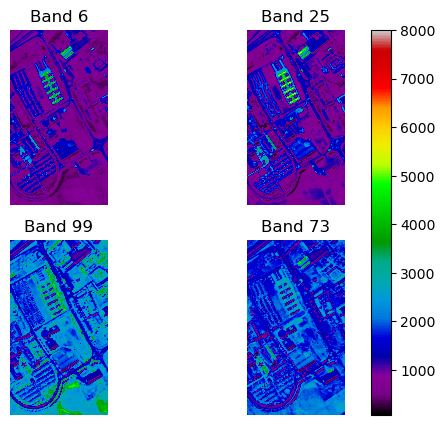

In [131]:
plot_band(data)

### Visualize the ground truth of the image

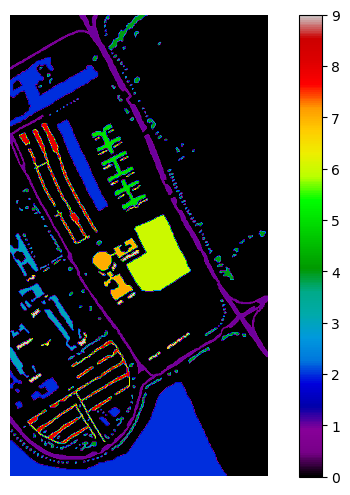

In [132]:
plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(ticks= range(0,10))
plt.show()

### Data Extraction


In [133]:
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [134]:
df = extract_pixels(data, gt)
df

100%|██████████| 103/103 [00:00<00:00, 108.56it/s]


band-1  band-2  band-3  band-4  band-5  band-6  band-7  band-8  \
0          647     499     464     371     291     319     365     322   
1          604     546     527     455     378     377     336     314   
2          621     746     556     360     285     300     274     276   
3          637     592     482     556     508     284     178     198   
4          625     560     480     360     377     341     264     208   
...        ...     ...     ...     ...     ...     ...     ...     ...   
207395     574     594     504     411     468     443     378     342   
207396     485     644     709     582     504     494     434     373   
207397     593     387     428     461     470     392     331     383   
207398     593     751     655     458     503     560     482     412   
207399     889     720     449     402     409     410     424     416   

        band-9  band-10  ...  band-95  band-96  band-97  band-98  band-99  \
0          296      305  ...     3416     3335     3256     3226     3205   
1          324      329  ...     2583     2538     2509     2511     2501   
2          332      319  ...     2288     2242     2193     2202     2225   
3          193      224  ...     2675     2609     2541     2551     2571   
4          231      266  ...     2392     2344     2289     2328     2415   
...        ...      ...  ...      ...      ...      ...      ...      ...   
207395     352      434  ...     2150     2157     2157     2169     2151   
207396     391      421  ...     2264     2295     2282     2265     2275   
207397     439      355  ...     2393     2407     2433     2413     2373   
207398     404      454  ...     2340     2333     2332     2288     2251   
207399     395      319  ...     2496     2502     2483     2488     2498   

        band-100  band-101  band-102  band-103  class  
0           3210      3221      3238      3250      0  
1           2468      2442      2464      2528      0  
2           2266      2308      2345      2361      0  
3           2569      2573      2620      2644      0  
4           2424      2386      2431      2456      0  
...          ...       ...       ...       ...    ...  
207395      2108      2077      2076      2136      0  
207396      2293      2274      2274      2258      0  
207397      2389      2382      2407      2423      0  
207398      2280      2312      2308      2289      0  
207399      2455      2416      2447      2485      0  

[207400 rows x 104 columns]

In [135]:
classes = {
    0: 'Background',
    1: 'Asphalt',
    2: 'Meadows',
    3: 'Gravel',
    4: 'Trees',
    5: 'Painted metal sheets',
    6: 'Bare Soil',
    7: 'Bitumen',
    8: 'Self-Blocking Bricks',
    9: 'Shadows'
}


### Save the dataset in CSV format

In [136]:
df.to_csv('Dataset.csv', index=False)

### Visualizing spectral signatures


In [137]:
def plot_signature(df,pixel_no=-1):
    if pixel_no == -1:
        pixel_no = np.random.randint(0, df.shape[0])
    plt.figure(figsize=(10, 2))
    plt.plot(range(1, df.shape[1]), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]} {classes[df.iloc[pixel_no, -1]]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

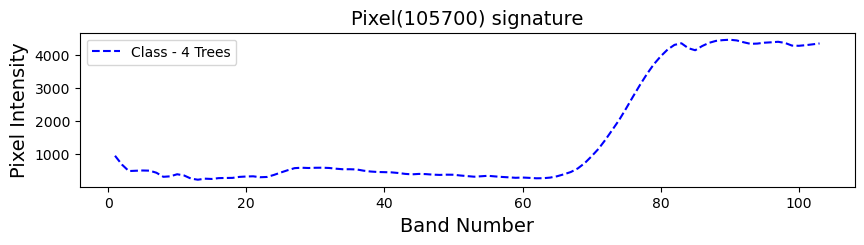

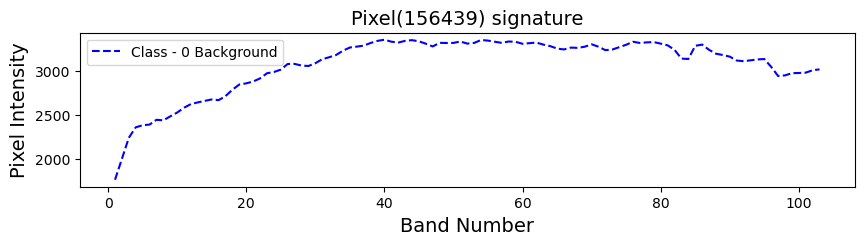

In [138]:
plot_signature(df,105700)
plot_signature(df)

### Average Signature of Different Classes

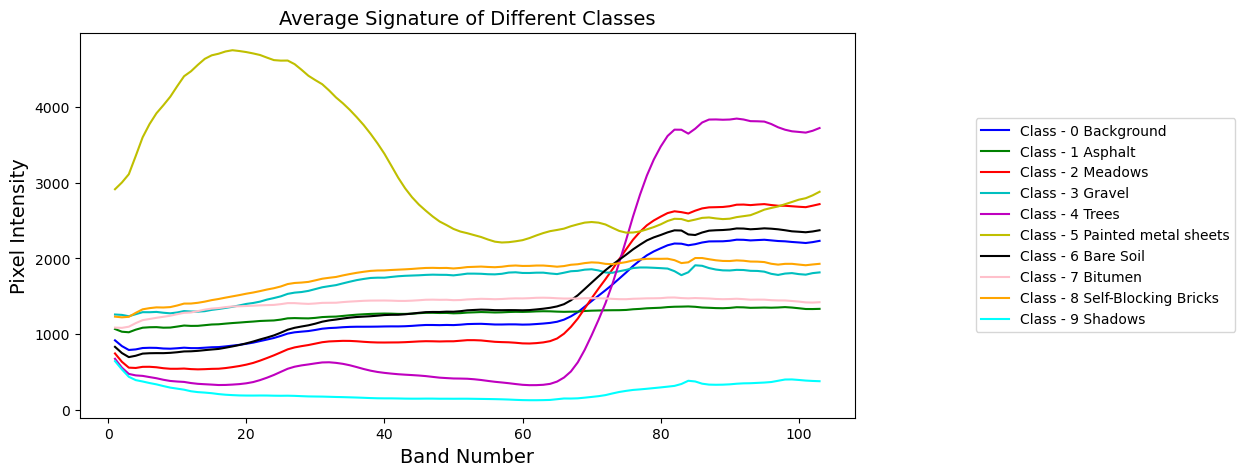

In [139]:
#plot different classes signature
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'pink', 'orange', 'cyan']
plt.figure(figsize=(10, 5))
for i in range(0, 10):
    plt.plot(range(1, df.shape[1]), df[df['class']==i].mean()[:-1].values.tolist(), label=f'Class - {i} {classes[i]}',color=colors[i])
plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5))
plt.title('Average Signature of Different Classes', fontsize=14)
plt.xlabel('Band Number', fontsize=14)
plt.ylabel('Pixel Intensity', fontsize=14)
plt.show()


### Class Distribution

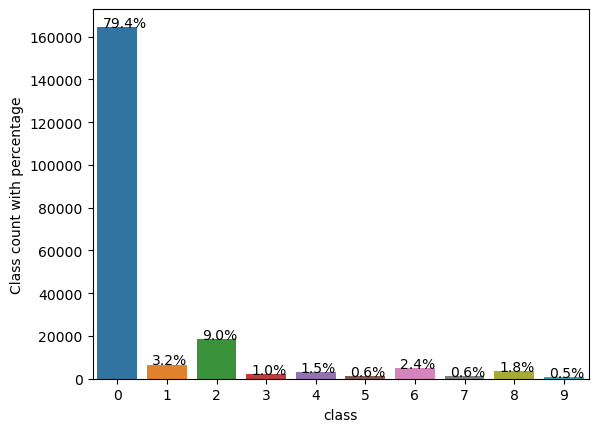

In [140]:

ax = sns.countplot(x='class', data=df[['class']])

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))

plt.ylabel('Class count with percentage')

plt.xlabel('class')


plt.show()

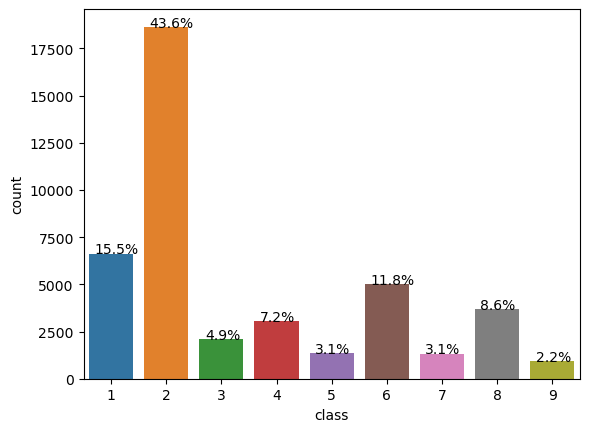

In [278]:
#class distrib after removing 0

ax = sns.countplot(x='class', data=df[['class']][df['class']!=0])
#add percentage to the plot

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df[['class']][df['class']!=0].shape[0]), (p.get_x()+0.1, p.get_height()+5))
                

### Remove the class 0 and creating a train test split

In [325]:
X = df[df['class']!=0].iloc[:, :-1].values

y = tf.keras.utils.to_categorical(df[df['class']!=0].iloc[:, -1].values , 
                                  num_classes= np.unique(gt).shape[0], 
                                  dtype='float32') 

#scaling
scaler = StandardScaler()

X = scaler.fit_transform(X)




In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y)


### Principal Component Analysis

In [328]:
def apply_pca(X, n_components):
    pca = PCA(n_components = n_components)

    principalComponents = pca.fit_transform(X)

    principalDf = pd.DataFrame(data = principalComponents, columns = [f'principal component {i}' for i in range(1, n_components+1)])

    ev=pca.explained_variance_ratio_

    return principalDf,ev


In [365]:
predictX,ev=apply_pca(X,20)

In [367]:
#train test

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(predictX, y, train_size = 0.8, stratify = y)

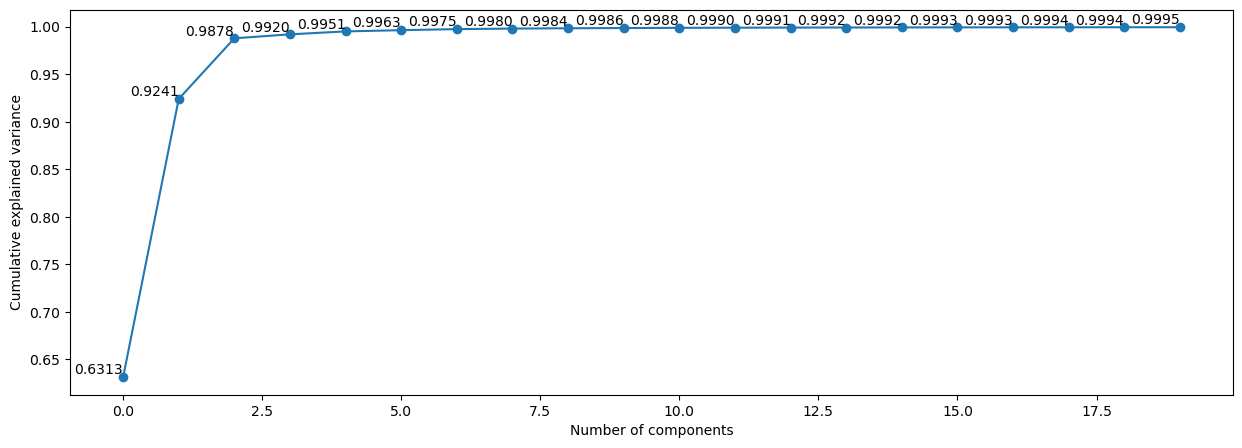

In [368]:
plt.figure(figsize=(15, 5))
plt.plot(ev.cumsum(), marker='o', linestyle='-')

# Annotate the plot with the values
for i, value in enumerate(ev.cumsum()):
    if(i%1==0):
        plt.text(i, value, f'{value:.4f}', ha='right', va='bottom')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Artificial Neural Network

In [149]:

model = Sequential(name='Pavia_University')

model.add(Input(shape = X_train[0].shape, name = 'Input_Layer'))

model.add(BatchNormalization(name = 'BatchNormalization'))

model.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
model.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))

model.add(Dropout(rate = 0.2, name = 'Dropout1',))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
model.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))

model.add(Dropout(rate = 0.2, name = 'Dropout2'))

model.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
model.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))

model.add(Dense(units = y_train.shape[1], activation= 'softmax', name = 'Output_Layer'))

model.summary()

Model: "Pavia_University"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchN  (None, 103)               412       
 ormalization)                                                   
                                                                 
 Layer1 (Dense)              (None, 128)               13312     
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                                  

In [150]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x = X_train, 
          y = y_train,
          validation_data = (X_test, y_test), 
          epochs = 100,
          callbacks = [es, checkpoint])

Epoch 1/100
1066/1070 [============================>.] - ETA: 0s - loss: 0.7971 - accuracy: 0.7120
Epoch 1: val_loss improved from inf to 0.47281, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 8s 5ms/step - loss: 0.7966 - accuracy: 0.7122 - val_loss: 0.4728 - val_accuracy: 0.8077
Epoch 2/100
1059/1070 [============================>.] - ETA: 0s - loss: 0.5500 - accuracy: 0.7954
Epoch 2: val_loss improved from 0.47281 to 0.42246, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 5s 5ms/step - loss: 0.5510 - accuracy: 0.7951 - val_loss: 0.4225 - val_accuracy: 0.8287
Epoch 3/100
1063/1070 [============================>.] - ETA: 0s - loss: 0.4858 - accuracy: 0.8133
Epoch 3: val_loss improved from 0.42246 to 0.41053, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 4s 4ms/step - loss: 0.4865 - accuracy: 0.8130 - val_loss: 0.4105 - val_accuracy: 0.8388
Epoch 4/100
1068/1070 [===

In [151]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()


In [152]:
from sklearn.metrics import classification_report


pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']))

268/268 [==============================] - 1s 2ms/step
                         precision    recall  f1-score   support

             1. Asphalt       0.95      0.96      0.95      1314
             2. Meadows       0.99      0.97      0.98      3784
              3. Gravel       0.65      0.86      0.74       319
               4. Trees       0.96      0.95      0.95       623
5. Painted metal sheets       1.00      1.00      1.00       269
           6. Bare Soil       0.92      0.98      0.95       942
             7. Bitumen       0.87      0.86      0.87       268
8. Self-Blocking Bricks       0.92      0.80      0.85       846
             9. Shadows       1.00      0.99      0.99       191

               accuracy                           0.95      8556
              macro avg       0.92      0.93      0.92      8556
           weighted avg       0.95      0.95      0.95      8556



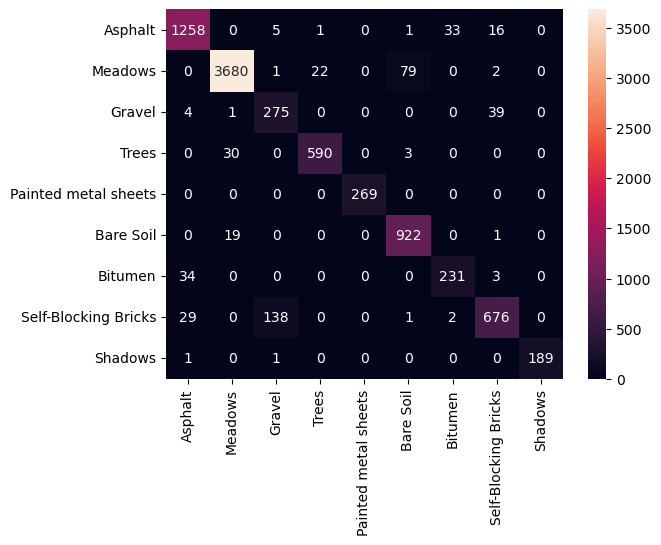

In [153]:

from sklearn.metrics import confusion_matrix


classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [154]:
#get predictions for all the pixels
dd=model.predict(scaler.transform(df.iloc[:, :-1].values))

# create a mask for class == 0
mask = df['class'] == 0

dd[mask] = 0

6482/6482 [==============================] - 11s 2ms/step


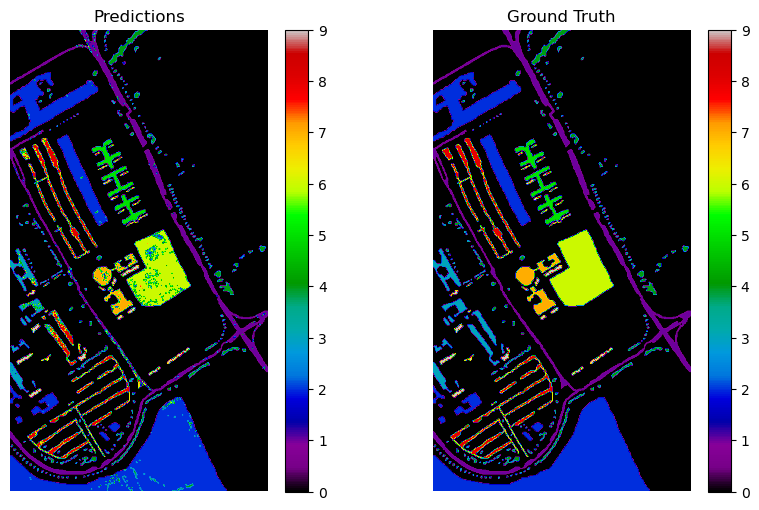

In [155]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Plot predictions and ground truth side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(np.argmax(dd, axis=1).reshape(610, 340), cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()


In [156]:
def zero_out_pixels(img, gt):
    """
    Set the value of pixels in img to 0 where the corresponding value in gt is 0.
    """
    img_zeroed = np.copy(img)
    
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if gt[i, j] == 0:
                img_zeroed[i, j] = 0 
    
    return img_zeroed

In [157]:
import scipy.ndimage as ndimage

def filter(x):
    ignored =np.where(x.astype(np.int64)==0)
    arr = np.delete(x.astype(np.int64), ignored)
    if(len(arr) == 0):
        return 0
    return np.bincount(arr).argmax()

def _apply_majority_filter(image, kernel_size=3):
    result = []
    image_int = image.astype(np.int64)
    filtered_output = ndimage.generic_filter(
        image_int,           
        function=filter,
        size=kernel_size
    )
    return zero_out_pixels(filtered_output,gt)

def apply_majority_filter(image, kernel_size=3, iterations=1):
    result = image.copy()
    for i in range(iterations):
        result = _apply_majority_filter(image, min(5, kernel_size+i*2))
    return result

In [158]:
majority_filtered = apply_majority_filter(np.argmax(dd, axis=1).reshape(610, 340), kernel_size=3, iterations=1)


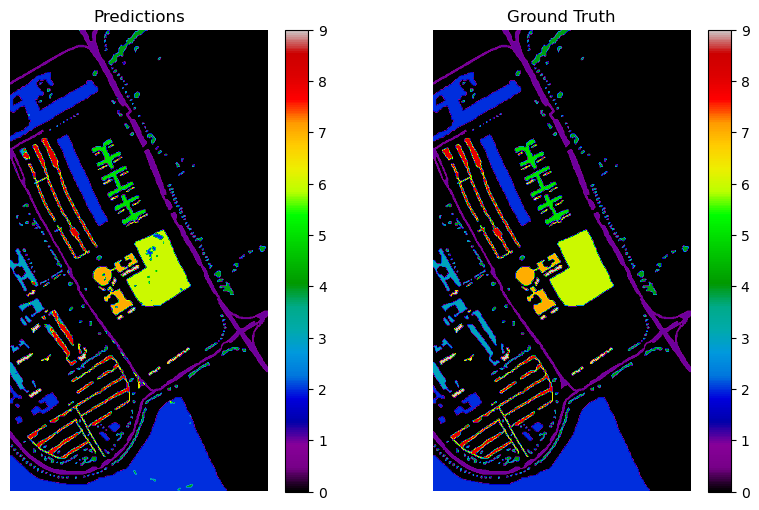

In [159]:
#plot the predictions after applying majority filter
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions

pred_im = axes[0].imshow(majority_filtered, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()

In [160]:
#print report after applying majority filter

print(classification_report(majority_filtered.ravel(), gt.ravel(), target_names = classes.append('Background')))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       0.99      0.98      0.99      6674
           2       1.00      0.99      0.99     18866
           3       0.70      0.94      0.80      1561
           4       0.97      0.98      0.97      3019
           5       1.00      1.00      1.00      1345
           6       0.97      1.00      0.98      4877
           7       0.95      1.00      0.97      1274
           8       0.96      0.84      0.90      4213
           9       1.00      1.00      1.00       947

    accuracy                           0.99    207400
   macro avg       0.95      0.97      0.96    207400
weighted avg       0.99      0.99      0.99    207400



In [161]:
scaled_data = scaler.transform(df.iloc[:, :-1].values)


In [369]:

model_pca = Sequential(name='Pavia_University_PCA')

model_pca.add(Input(shape = X_train_pca.iloc[0].shape, name = 'Input_Layer'))

model_pca.add(BatchNormalization(name = 'BatchNormalization'))

model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
model_pca.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))
model_pca.add(Dropout(rate = 0.2, name = 'Dropout1',))

model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
model_pca.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))
model_pca.add(Dropout(rate = 0.2, name = 'Dropout2'))

model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
model_pca.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))


model_pca.add(Dense(units = y_train.shape[1], activation= 'softmax', name = 'Output_Layer'))

model_pca.summary()

Model: "Pavia_University_PCA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BatchNormalization (BatchN  (None, 20)                80        
 ormalization)                                                   
                                                                 
 Layer1 (Dense)              (None, 128)               2688      
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 128)               16512     
                                                                 
 Layer4 (Dense)              (None, 128)               16512     
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                              

In [370]:
# fit with pdf

model_pca.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 8,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Pavia_University_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model_pca.fit(x = X_train_pca, 
          y = y_train_pca,
          validation_data = (X_test_pca, y_test_pca),
          epochs = 100,
          callbacks = [es, checkpoint])

Epoch 1/100
1065/1070 [============================>.] - ETA: 0s - loss: 0.6198 - accuracy: 0.7783
Epoch 1: val_loss improved from inf to 0.29836, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 8s 5ms/step - loss: 0.6188 - accuracy: 0.7786 - val_loss: 0.2984 - val_accuracy: 0.8945
Epoch 2/100
1067/1070 [============================>.] - ETA: 0s - loss: 0.3338 - accuracy: 0.8815
Epoch 2: val_loss improved from 0.29836 to 0.22633, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 4s 4ms/step - loss: 0.3335 - accuracy: 0.8816 - val_loss: 0.2263 - val_accuracy: 0.9267
Epoch 3/100
1060/1070 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.9094
Epoch 3: val_loss improved from 0.22633 to 0.19186, saving model to Pavia_University_Model.h5
1070/1070 [==============================] - 4s 4ms/step - loss: 0.2683 - accuracy: 0.9095 - val_loss: 0.1919 - val_accuracy: 0.9370
Epoch 4/100
1056/1070 [===

In [358]:
hist = pd.DataFrame(data= history.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist.index, y = hist.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist.index, y = hist.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

In [359]:


predd = np.argmax(model_pca.predict(X_test_pca), axis=1)

# Classification Report
print(classification_report(predd, np.argmax(y_test_pca, 1),
      target_names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']))

268/268 [==============================] - 1s 2ms/step
                         precision    recall  f1-score   support

             1. Asphalt       0.94      0.90      0.92      1396
             2. Meadows       0.97      0.93      0.95      3876
              3. Gravel       0.74      0.80      0.76       388
               4. Trees       0.92      0.96      0.94       588
5. Painted metal sheets       1.00      1.00      1.00       269
           6. Bare Soil       0.77      0.86      0.81       896
             7. Bitumen       0.75      0.83      0.79       241
8. Self-Blocking Bricks       0.83      0.86      0.84       713
             9. Shadows       1.00      1.00      1.00       189

               accuracy                           0.91      8556
              macro avg       0.88      0.90      0.89      8556
           weighted avg       0.91      0.91      0.91      8556



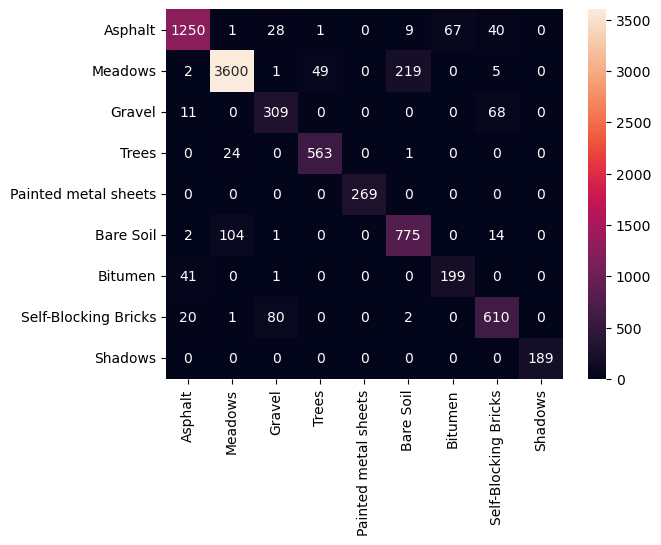

In [360]:

from sklearn.metrics import confusion_matrix


classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

mat = confusion_matrix(np.add(predd, 1), np.add(np.argmax(y_test_pca, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

In [361]:
def generate_image_from_pred(pred, gt):
    img = gt.copy()
    k=0
    index = 0
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
           
            if gt[i][j]==0:
                k+=1
                img[i][j] = 0  
                continue
            else:
                img[i][j] = pred[index]
                index+=1
    print(index)     
    return img

In [362]:
dd=model_pca.predict(predictX)



1337/1337 [==============================] - 3s 2ms/step


In [363]:
img=generate_image_from_pred(np.argmax(dd, axis=1), gt)

42776


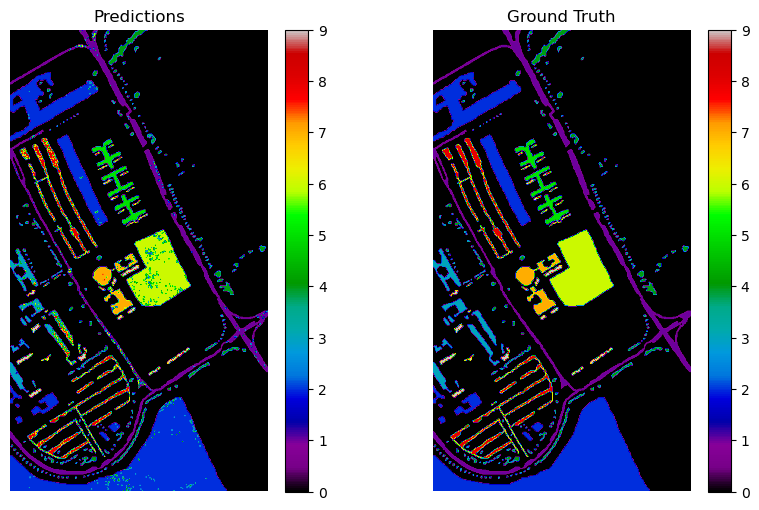

In [315]:


# Plot predictions and ground truth side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(img, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()

In [316]:
#accuracy

from sklearn.metrics import classification_report

print(classification_report(img.ravel(), gt.ravel(), target_names = classes.append('Background')))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       0.96      0.96      0.96      6589
           2       0.99      0.98      0.98     18818
           3       0.82      0.85      0.83      2016
           4       0.98      0.98      0.98      3052
           5       1.00      1.00      1.00      1345
           6       0.94      0.96      0.95      4915
           7       0.90      0.88      0.89      1354
           8       0.89      0.88      0.88      3740
           9       1.00      1.00      1.00       947

    accuracy                           0.99    207400
   macro avg       0.95      0.95      0.95    207400
weighted avg       0.99      0.99      0.99    207400



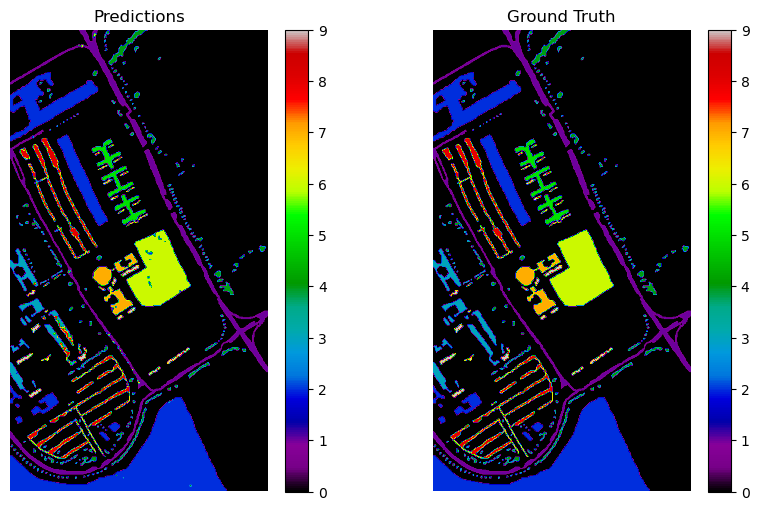

In [317]:
#apply majority filter
majority_filtered = apply_majority_filter(img, kernel_size=3, iterations=1)

#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(majority_filtered, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()

In [318]:
#cout number of errors between the ground truth and the predictions after applying majority filter
err=0
for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
        if gt[i][j] != majority_filtered[i][j]:
            err+=1
print(err)
print(gt.ravel().shape[0]) 
print(err/gt.ravel().shape[0])

            


653
207400
0.0031485053037608487


In [319]:
#majority filter report
print(classification_report(majority_filtered.ravel(), gt.ravel(), target_names = classes.append('Background')))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       0.99      0.98      0.99      6675
           2       1.00      0.99      1.00     18763
           3       0.88      0.95      0.91      1937
           4       0.99      1.00      0.99      3036
           5       1.00      1.00      1.00      1345
           6       0.98      1.00      0.99      4956
           7       0.95      0.98      0.96      1289
           8       0.96      0.93      0.94      3828
           9       1.00      1.00      1.00       947

    accuracy                           1.00    207400
   macro avg       0.97      0.98      0.98    207400
weighted avg       1.00      1.00      1.00    207400



# Clustering


100%|██████████| 18/18 [00:53<00:00,  2.95s/it]


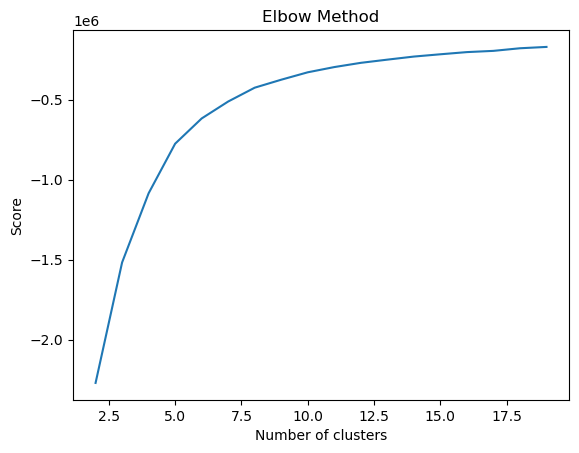

In [180]:
#kmean clustering
from sklearn.cluster import KMeans
from tqdm import tqdm

#make all number of clusters from 2 to 10
kmeans = [KMeans(n_clusters = i) for i in range(2, 20)]

#fit the model
score = [kmeans[i].fit(X_train).score(X_train) for i in tqdm(range(len(kmeans)))]


#show the predictions of all the models
plt.plot(range(2, 20), score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()





In [181]:
#accuracy of the model

from sklearn.metrics import accuracy_score

for i in range(1, 9):
    qqq=kmeans[i].predict(scaled_data)
    qqq[mask]=0
    print(f'Accuracy with {i+1} clusters: {accuracy_score(df["class"], qqq)}')

Accuracy with 2 clusters: 0.7938428158148505
Accuracy with 3 clusters: 0.8248553519768563
Accuracy with 4 clusters: 0.7996383799421408
Accuracy with 5 clusters: 0.7939296046287367
Accuracy with 6 clusters: 0.7954918032786885
Accuracy with 7 clusters: 0.8117261330761812
Accuracy with 8 clusters: 0.8108630665380906
Accuracy with 9 clusters: 0.8152892960462874


In [182]:
from sklearn.metrics import classification_report


for i in range(1, 9):
    qqq=kmeans[i].predict(scaled_data)
    qqq[mask]=0
    print(f'Classification Report with {i+1} clusters:\n{classification_report(df["class"], qqq)}')





Classification Report with 2 clusters:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    164624
           1       0.00      0.00      0.00      6631
           2       0.00      0.00      0.00     18649
           3       0.00      0.00      0.00      2099
           4       0.00      0.00      0.00      3064
           5       0.00      0.00      0.00      1345
           6       0.00      0.00      0.00      5029
           7       0.00      0.00      0.00      1330
           8       0.00      0.00      0.00      3682
           9       0.00      0.00      0.00       947

    accuracy                           0.79    207400
   macro avg       0.09      0.10      0.10    207400
weighted avg       0.72      0.79      0.75    207400

Classification Report with 3 clusters:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    164624
           1       0.21      0.40      0.28      6631


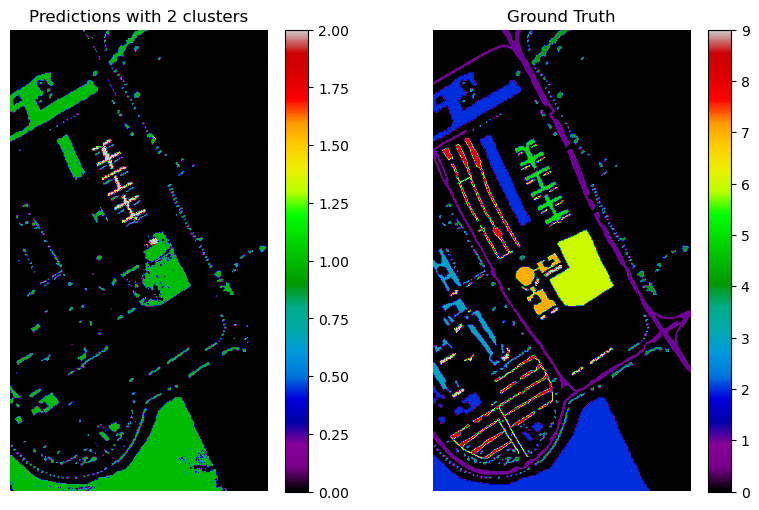

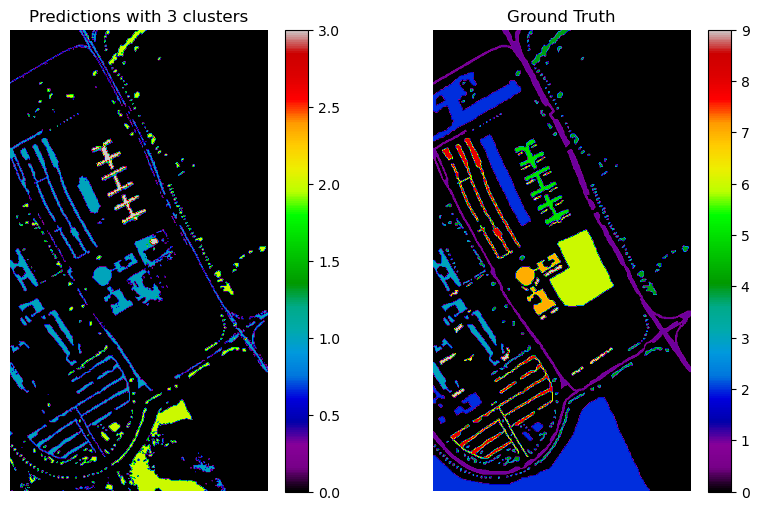

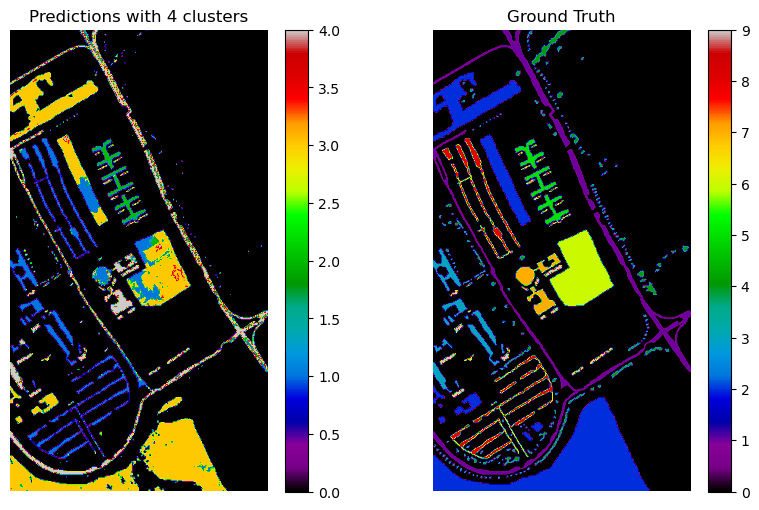

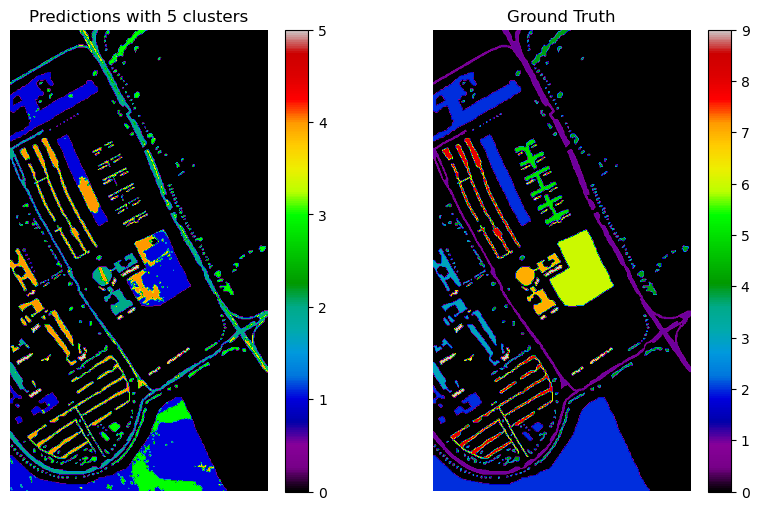

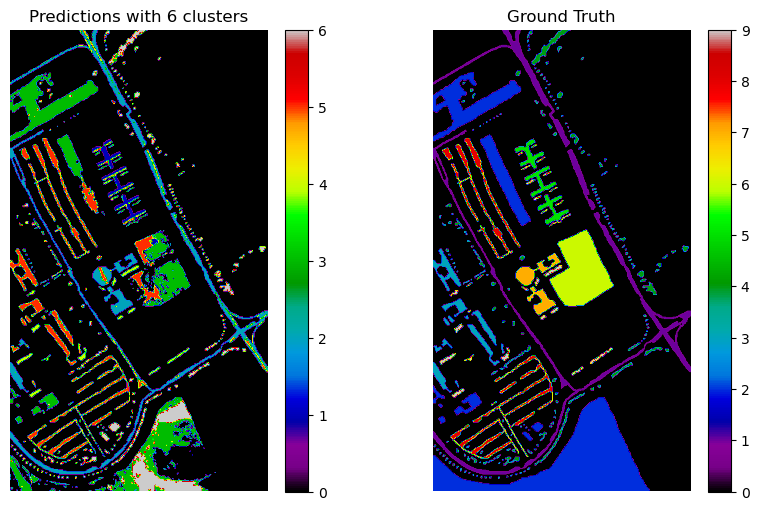

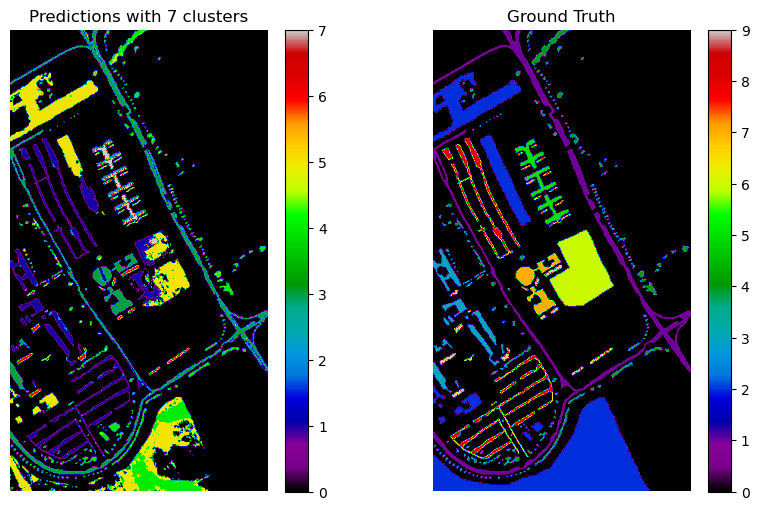

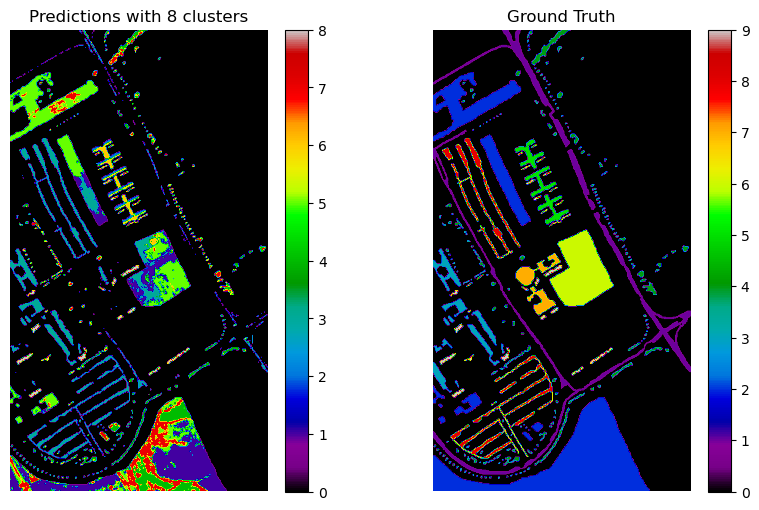

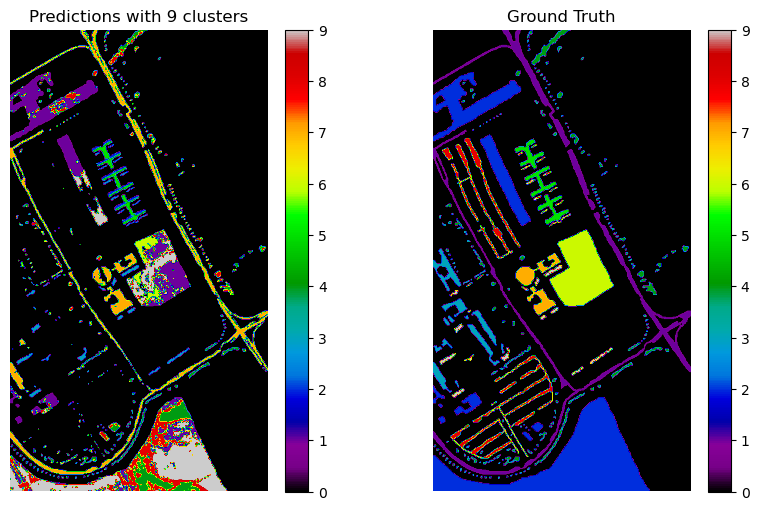

In [183]:
for i in range(1, 9):
    qqq=kmeans[i].predict(scaled_data)
    qqq[mask]=0
    qqq=qqq.reshape(610, 340)   
    # Plot predictions and ground truth side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Plot predictions
    pred_im = axes[0].imshow(qqq, cmap='nipy_spectral')
    axes[0].axis('off')
    axes[0].set_title(f'Predictions with {i+1} clusters')
    cbar_pred = plt.colorbar(pred_im, ax=axes[0])

    # Plot ground truth
    gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
    axes[1].axis('off')
    axes[1].set_title('Ground Truth')
    cbar_gt = plt.colorbar(gt_im, ax=axes[1])

    plt.show()
    

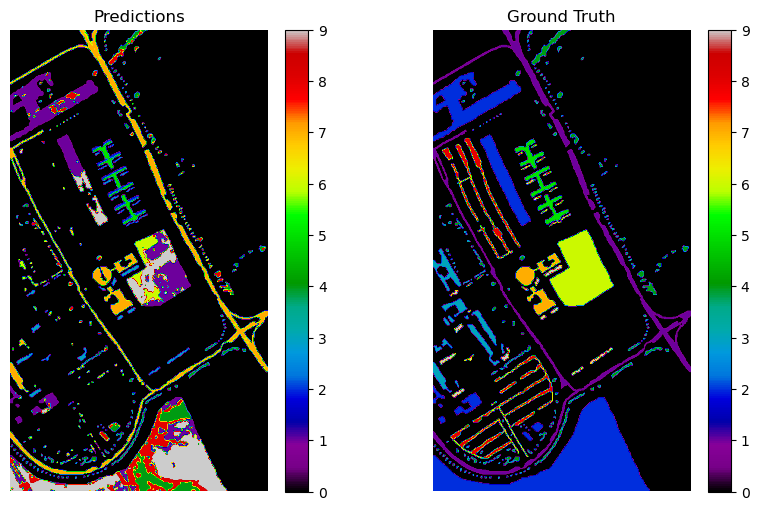

Accuracy with 9 clusters after applying majority filter: 0.8170443587270974


In [184]:
from sklearn.metrics import accuracy_score
#apply majority filter on the last model
qqq=kmeans[8].predict(scaled_data)
qqq[mask]=0
qqq=qqq.reshape(610, 340)
majority_filtered = apply_majority_filter(qqq, kernel_size=3, iterations=1)

#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(majority_filtered, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()

#print accuracy after majority

print(f'Accuracy with 9 clusters after applying majority filter: {accuracy_score(gt.ravel(), majority_filtered.ravel())}')

### KNN


In [387]:
#implement knn with k=8 but the neighbours are actually the 8 pixels that are around the pixel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#reshape the data

#scale all df
scaler = StandardScaler()
XX = scaler.fit_transform(df.iloc[:, :-1].values)
yy=df['class'].values
#make the model
from sklearn.metrics import f1_score


def knn(k):
    knn = KNeighborsClassifier(n_neighbors=k)

    #fit the model
    knn.fit(XX,yy)



    #plot the predictions
    pred = knn.predict(XX)

    pred = pred.reshape(610, 340)

    # Plot predictions and ground truth side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Plot predictions
    pred_im = axes[0].imshow(pred, cmap='nipy_spectral')
    axes[0].axis('off')
    axes[0].set_title(f'Predictions with {k} neighbours')
    cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

    # Plot ground truth
    gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
    axes[1].axis('off')
    axes[1].set_title('Ground Truth')
    cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

    plt.show()
  
    return pred







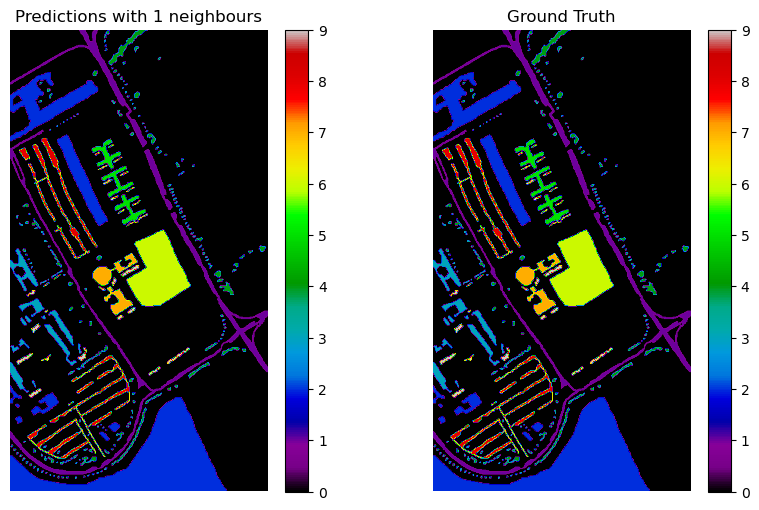

Classification Report with 1 neighbours:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164624
           1       1.00      1.00      1.00      6631
           2       1.00      1.00      1.00     18649
           3       1.00      1.00      1.00      2099
           4       1.00      1.00      1.00      3064
           5       1.00      1.00      1.00      1345
           6       1.00      1.00      1.00      5029
           7       1.00      1.00      1.00      1330
           8       1.00      1.00      1.00      3682
           9       1.00      1.00      1.00       947

    accuracy                           1.00    207400
   macro avg       1.00      1.00      1.00    207400
weighted avg       1.00      1.00      1.00    207400



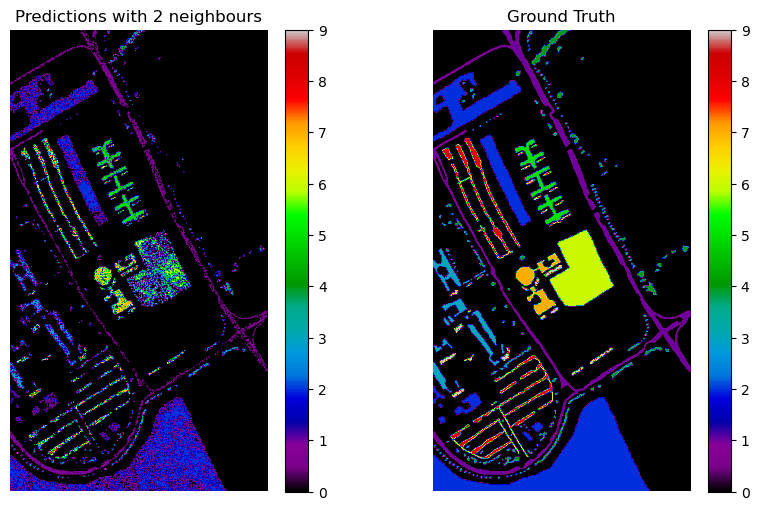

Classification Report with 2 neighbours:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    164624
           1       0.96      0.47      0.63      6631
           2       0.96      0.64      0.77     18649
           3       0.85      0.54      0.66      2099
           4       1.00      0.33      0.50      3064
           5       1.00      0.82      0.90      1345
           6       1.00      0.32      0.48      5029
           7       1.00      0.63      0.77      1330
           8       1.00      0.44      0.62      3682
           9       1.00      0.41      0.58       947

    accuracy                           0.90    207400
   macro avg       0.97      0.56      0.69    207400
weighted avg       0.91      0.90      0.89    207400



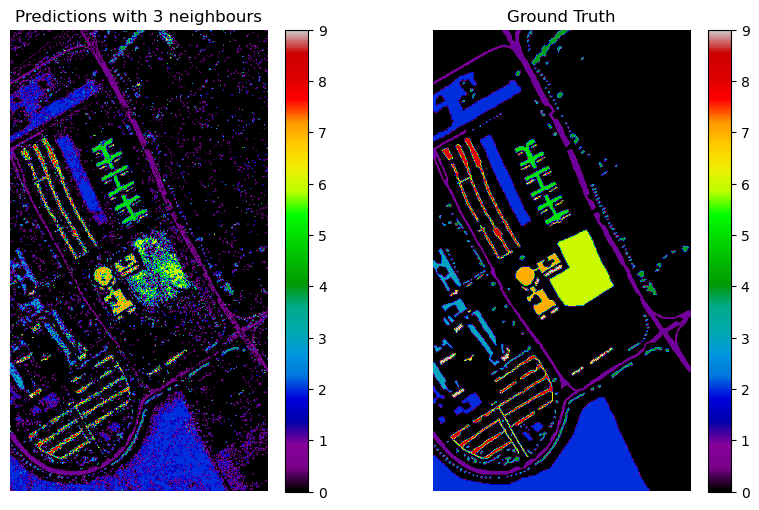

Classification Report with 3 neighbours:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    164624
           1       0.78      0.62      0.69      6631
           2       0.79      0.80      0.80     18649
           3       0.79      0.62      0.69      2099
           4       0.78      0.51      0.61      3064
           5       0.89      0.93      0.91      1345
           6       0.77      0.47      0.58      5029
           7       0.78      0.78      0.78      1330
           8       0.74      0.64      0.68      3682
           9       0.77      0.63      0.69       947

    accuracy                           0.90    207400
   macro avg       0.80      0.69      0.74    207400
weighted avg       0.90      0.90      0.90    207400



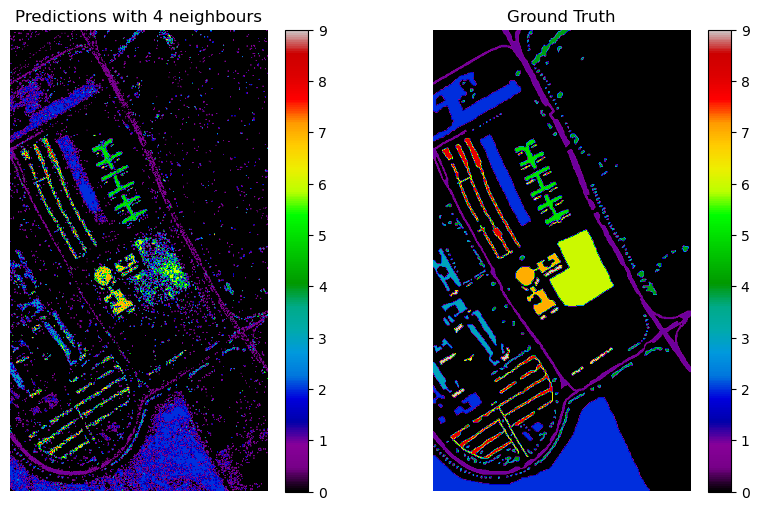

Classification Report with 4 neighbours:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    164624
           1       0.83      0.43      0.57      6631
           2       0.83      0.65      0.73     18649
           3       0.75      0.49      0.60      2099
           4       0.82      0.27      0.41      3064
           5       0.92      0.86      0.89      1345
           6       0.78      0.31      0.45      5029
           7       0.78      0.71      0.74      1330
           8       0.76      0.48      0.59      3682
           9       0.82      0.36      0.50       947

    accuracy                           0.88    207400
   macro avg       0.82      0.55      0.64    207400
weighted avg       0.88      0.88      0.87    207400



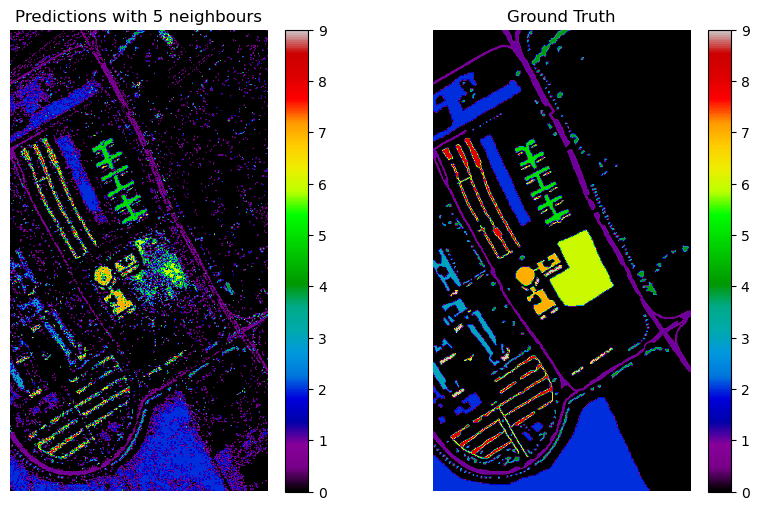

Classification Report with 5 neighbours:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93    164624
           1       0.74      0.53      0.62      6631
           2       0.75      0.75      0.75     18649
           3       0.73      0.52      0.61      2099
           4       0.74      0.36      0.49      3064
           5       0.86      0.91      0.89      1345
           6       0.73      0.33      0.46      5029
           7       0.75      0.75      0.75      1330
           8       0.70      0.56      0.62      3682
           9       0.72      0.51      0.60       947

    accuracy                           0.88    207400
   macro avg       0.76      0.62      0.67    207400
weighted avg       0.87      0.88      0.87    207400



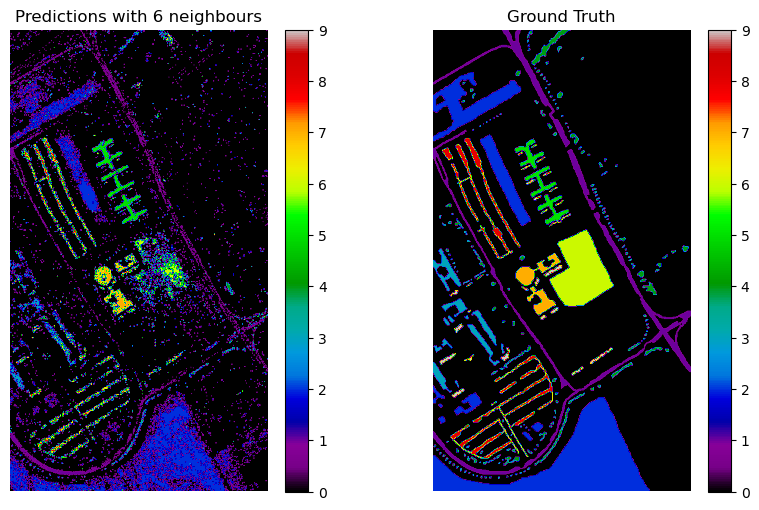

Classification Report with 6 neighbours:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    164624
           1       0.78      0.41      0.54      6631
           2       0.79      0.65      0.71     18649
           3       0.75      0.45      0.56      2099
           4       0.80      0.24      0.37      3064
           5       0.88      0.87      0.88      1345
           6       0.76      0.27      0.40      5029
           7       0.74      0.72      0.73      1330
           8       0.70      0.47      0.56      3682
           9       0.75      0.33      0.46       947

    accuracy                           0.87    207400
   macro avg       0.78      0.54      0.61    207400
weighted avg       0.86      0.87      0.86    207400



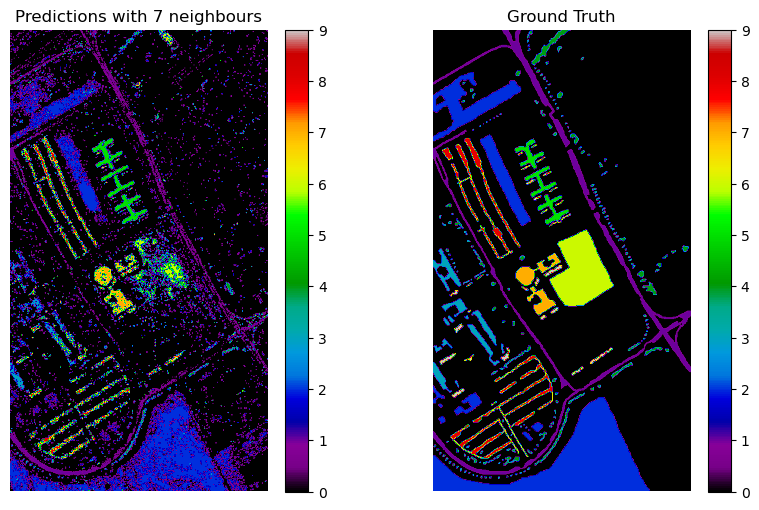

Classification Report with 7 neighbours:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92    164624
           1       0.72      0.48      0.58      6631
           2       0.73      0.71      0.72     18649
           3       0.73      0.48      0.58      2099
           4       0.73      0.29      0.42      3064
           5       0.85      0.91      0.88      1345
           6       0.70      0.29      0.41      5029
           7       0.70      0.75      0.72      1330
           8       0.66      0.54      0.59      3682
           9       0.70      0.46      0.55       947

    accuracy                           0.87    207400
   macro avg       0.74      0.59      0.64    207400
weighted avg       0.86      0.87      0.86    207400



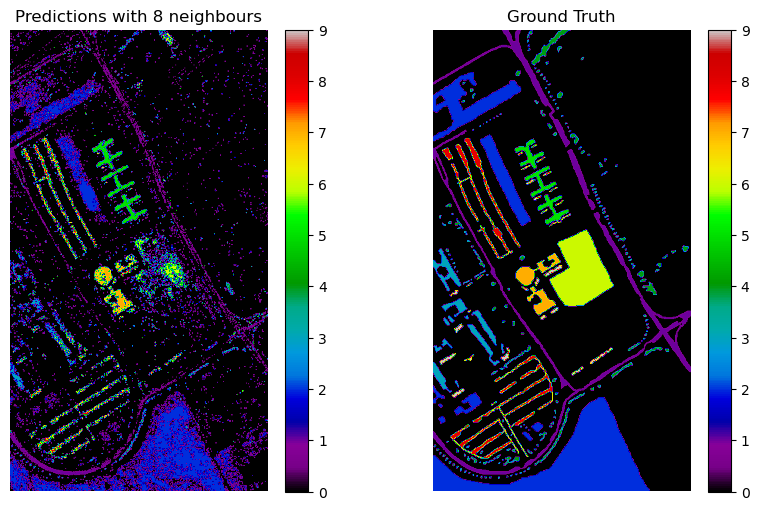

Classification Report with 8 neighbours:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92    164624
           1       0.74      0.39      0.51      6631
           2       0.76      0.64      0.70     18649
           3       0.72      0.43      0.54      2099
           4       0.78      0.21      0.33      3064
           5       0.86      0.88      0.87      1345
           6       0.76      0.23      0.36      5029
           7       0.72      0.72      0.72      1330
           8       0.68      0.46      0.55      3682
           9       0.71      0.29      0.41       947

    accuracy                           0.87    207400
   macro avg       0.76      0.52      0.59    207400
weighted avg       0.86      0.87      0.85    207400



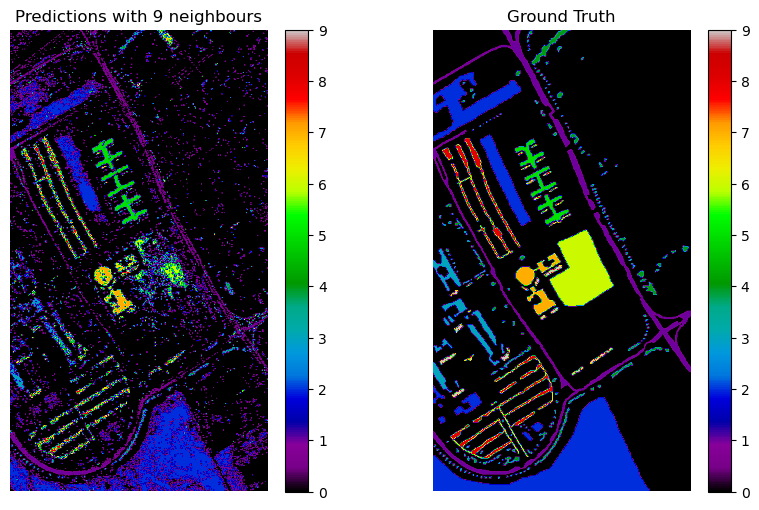

Classification Report with 9 neighbours:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92    164624
           1       0.71      0.44      0.55      6631
           2       0.73      0.69      0.71     18649
           3       0.72      0.42      0.53      2099
           4       0.74      0.26      0.39      3064
           5       0.83      0.91      0.87      1345
           6       0.71      0.25      0.37      5029
           7       0.68      0.75      0.72      1330
           8       0.64      0.51      0.57      3682
           9       0.65      0.38      0.48       947

    accuracy                           0.86    207400
   macro avg       0.73      0.56      0.61    207400
weighted avg       0.86      0.86      0.85    207400



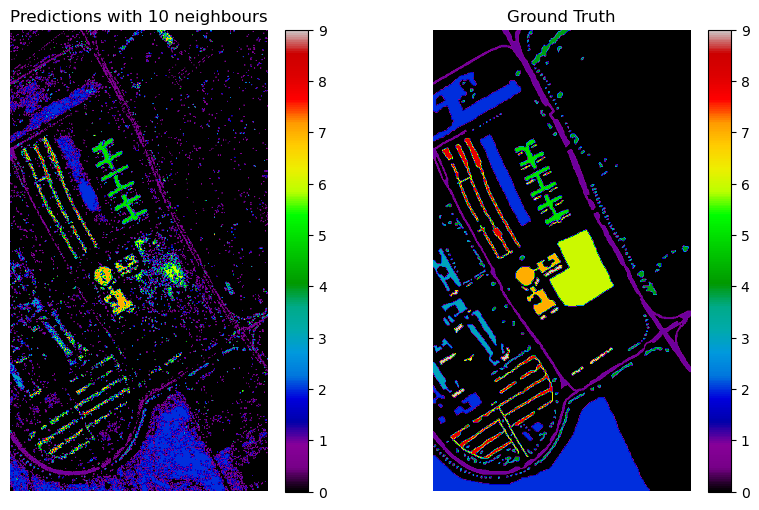

Classification Report with 10 neighbours:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92    164624
           1       0.74      0.38      0.50      6631
           2       0.74      0.64      0.69     18649
           3       0.73      0.41      0.52      2099
           4       0.78      0.20      0.32      3064
           5       0.85      0.89      0.87      1345
           6       0.73      0.21      0.33      5029
           7       0.69      0.73      0.71      1330
           8       0.64      0.45      0.53      3682
           9       0.68      0.26      0.37       947

    accuracy                           0.86    207400
   macro avg       0.75      0.51      0.58    207400
weighted avg       0.85      0.86      0.85    207400



In [389]:
l=[]
for i in range(1,11):
    l.append(knn(i))
    #print report for last pred
    print(f'Classification Report with {i} neighbours:\n{classification_report(df["class"], l[-1].ravel())}')

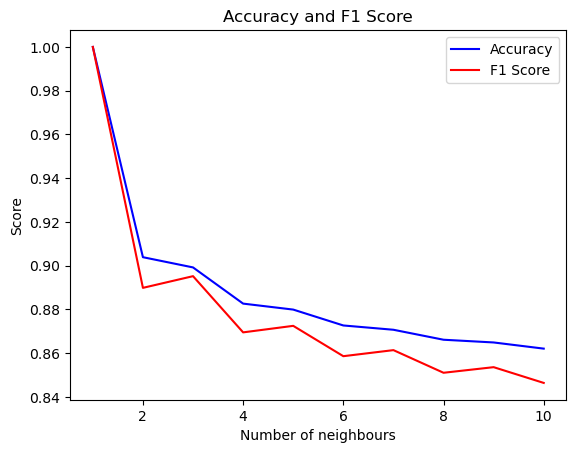

In [392]:
acc=[]
f=[]

for i in l:
    acc.append(accuracy_score(df["class"], i.ravel()))
    f.append(f1_score(df["class"], i.ravel(), average='weighted'))

#plot acc and f in the same plot

fig, ax = plt.subplots()
ax.plot(range(1,11), acc, 'b', label='Accuracy')
ax.plot(range(1,11), f, 'r', label='F1 Score')
ax.legend()
plt.xlabel('Number of neighbours')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score')
plt.show()

   

In [393]:
#split XX and yy
xxxtrain, xxxtest, yyytrain, yyytest = train_test_split(XX, yy, train_size = 0.8, stratify = yy)

In [394]:
m=KNeighborsClassifier(n_neighbors=1)

m.fit(xxxtrain,yyytrain)

p=m.predict(xxxtest)

#report 

print(f'Classification Report with 1 neighbour:\n{classification_report(yyytest, p)}')



Classification Report with 1 neighbour:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     32925
           1       0.43      0.43      0.43      1326
           2       0.53      0.60      0.56      3730
           3       0.45      0.43      0.44       420
           4       0.33      0.31      0.32       613
           5       0.77      0.79      0.78       269
           6       0.29      0.31      0.30      1006
           7       0.55      0.59      0.57       266
           8       0.39      0.45      0.42       736
           9       0.43      0.47      0.45       189

    accuracy                           0.79     41480
   macro avg       0.51      0.52      0.51     41480
weighted avg       0.79      0.79      0.79     41480



In [376]:
pred=pred.reshape(610, 340)

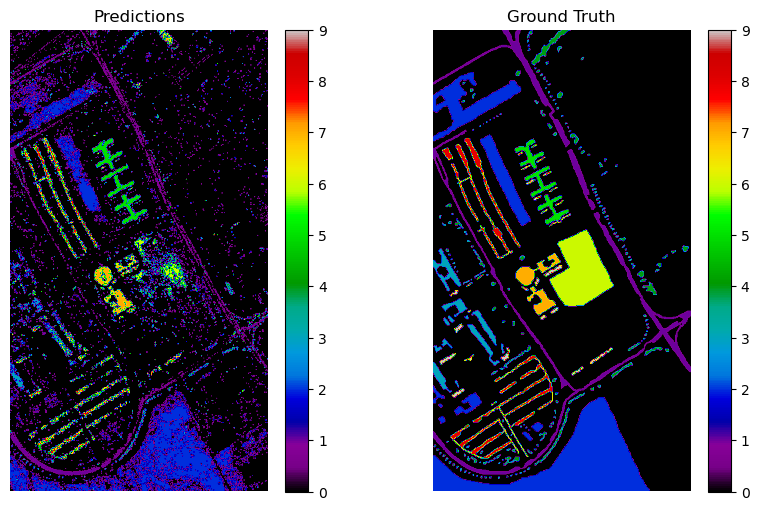

In [377]:
# Plot predictions and ground truth side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(pred, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0])

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1])

plt.show()

In [378]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(df['class'], pred.reshape(-1)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    164624
           1       0.70      0.43      0.53      6631
           2       0.72      0.67      0.69     18649
           3       0.71      0.41      0.52      2099
           4       0.73      0.23      0.34      3064
           5       0.83      0.91      0.87      1345
           6       0.72      0.23      0.34      5029
           7       0.67      0.74      0.70      1330
           8       0.63      0.49      0.55      3682
           9       0.64      0.35      0.45       947

    accuracy                           0.86    207400
   macro avg       0.72      0.54      0.59    207400
weighted avg       0.85      0.86      0.85    207400



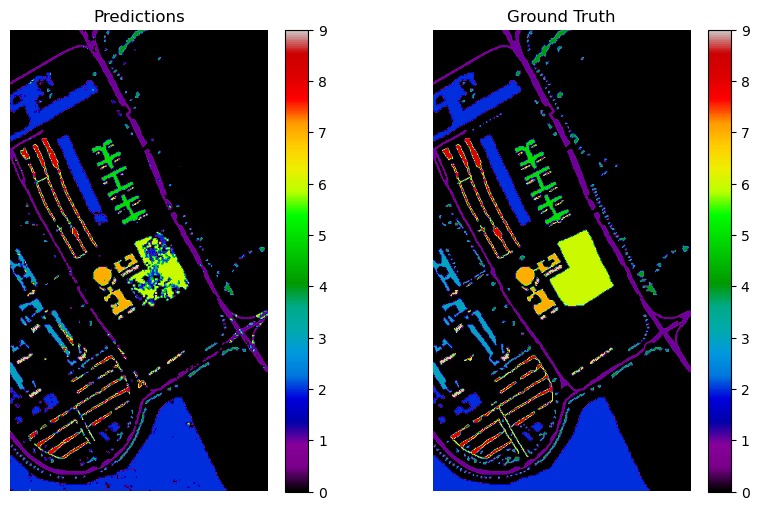

In [379]:
#apply majority filter
majority_filtered = apply_majority_filter(pred, kernel_size=3, iterations=1)

#plot
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(majority_filtered, cmap='nipy_spectral')
axes[0].axis('off')

axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()

In [380]:
#accuracy after majority filter
print(f'Accuracy after applying majority filter: {accuracy_score(gt.ravel(), majority_filtered.ravel())}')

Accuracy after applying majority filter: 0.9706798457087753


In [381]:
#report after majority filter

print(classification_report(majority_filtered.ravel(), gt.ravel(), target_names = classes.append('Background')))




              precision    recall  f1-score   support

           0       1.00      0.97      0.99    168902
           1       0.87      0.99      0.93      5809
           2       0.97      0.94      0.95     19222
           3       0.85      0.92      0.88      1942
           4       0.54      1.00      0.71      1669
           5       1.00      1.00      1.00      1346
           6       0.56      0.99      0.71      2828
           7       0.97      0.89      0.93      1443
           8       0.87      0.92      0.90      3478
           9       0.80      1.00      0.89       761

    accuracy                           0.97    207400
   macro avg       0.84      0.96      0.89    207400
weighted avg       0.98      0.97      0.97    207400



# RF

In [396]:
#import rf classifier

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, random_state = 42)


In [399]:
model.fit(X_train, np.argmax(y_train, axis=1))

pred = model.predict(X_test)

# Classification Report

print(classification_report(pred, np.argmax(y_test, 1), target_names = classes.append('Background')))

              precision    recall  f1-score   support

           1       0.95      0.93      0.94      1344
           2       0.99      0.95      0.97      3889
           3       0.81      0.87      0.84       392
           4       0.93      0.97      0.95       589
           5       1.00      1.00      1.00       269
           6       0.83      0.94      0.88       885
           7       0.80      0.91      0.85       232
           8       0.91      0.88      0.89       767
           9       1.00      1.00      1.00       189

    accuracy                           0.94      8556
   macro avg       0.91      0.94      0.92      8556
weighted avg       0.94      0.94      0.94      8556



<Axes: >

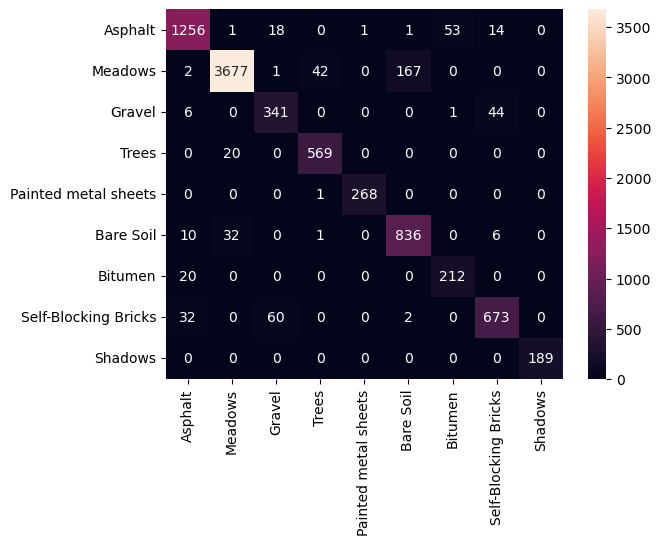

In [405]:
#confusion matrix

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

df_cm = pd.DataFrame(mat, index = classes, columns = classes)


sns.heatmap(df_cm, annot=True, fmt='d')

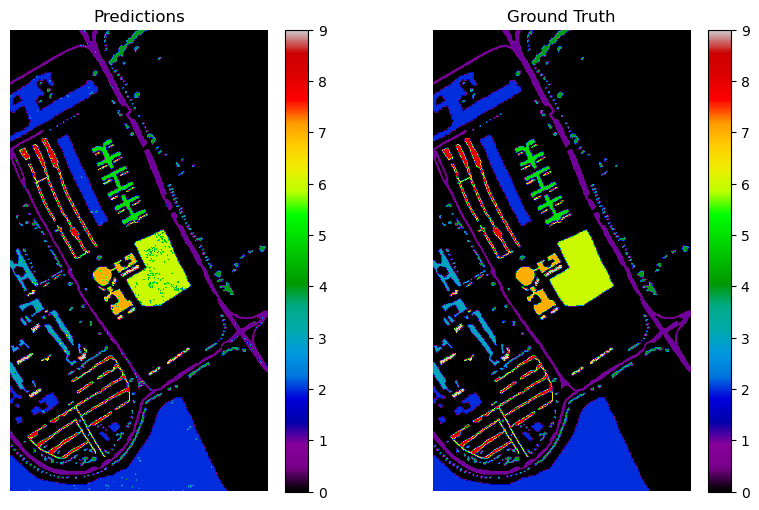

In [400]:
#print image   and gt

imggg = model.predict(scaled_data)

imggg[mask] = 0

imggg = imggg.reshape(610, 340)

# Plot predictions and ground truth side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(imggg, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 450}
Best Score: 0.9281706995933433


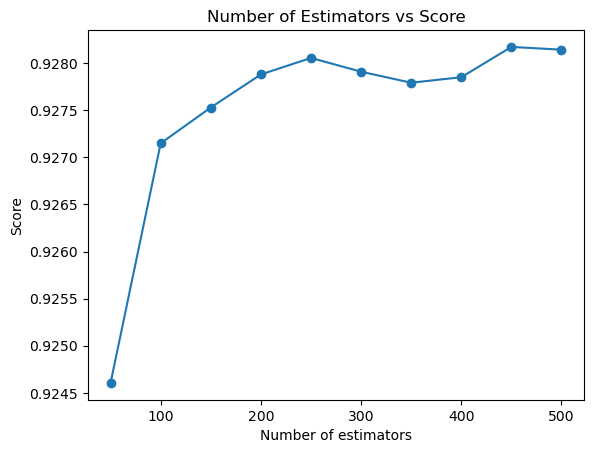

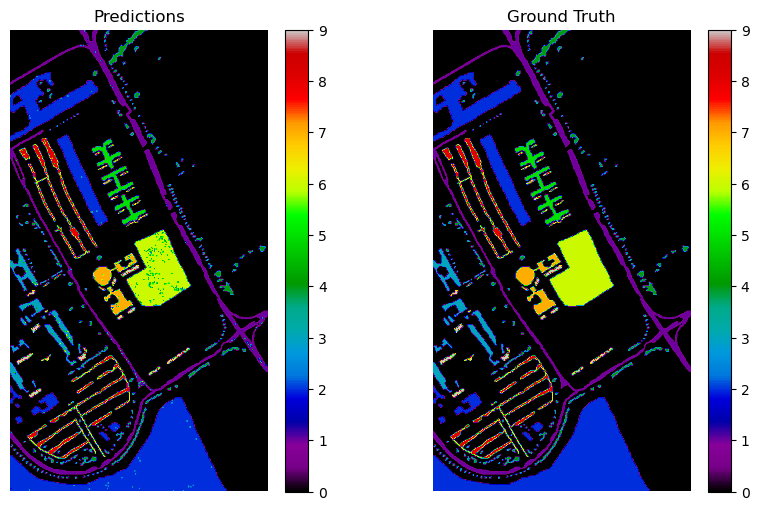

In [406]:
#test many number of estimators in the rf with grid search

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, np.argmax(y_train, axis=1))

best_model=grid_search.best_estimator_
#print best params and best score


print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

#plot the score for every model

scores = grid_search.cv_results_['mean_test_score']
estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

plt.plot(estimators, scores, marker='o', linestyle='-')

plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.title('Number of Estimators vs Score')

plt.show()

##plot predicted image and gt


imggg = best_model.predict(scaled_data)

imggg[mask] = 0

imggg = imggg.reshape(610, 340)

# Plot predictions and ground truth side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot predictions
pred_im = axes[0].imshow(imggg, cmap='nipy_spectral')
axes[0].axis('off')
axes[0].set_title('Predictions')
cbar_pred = plt.colorbar(pred_im, ax=axes[0], ticks=range(10))

# Plot ground truth
gt_im = axes[1].imshow(gt, cmap='nipy_spectral')
axes[1].axis('off')
axes[1].set_title('Ground Truth')
cbar_gt = plt.colorbar(gt_im, ax=axes[1], ticks=range(10))

plt.show()








<Axes: >

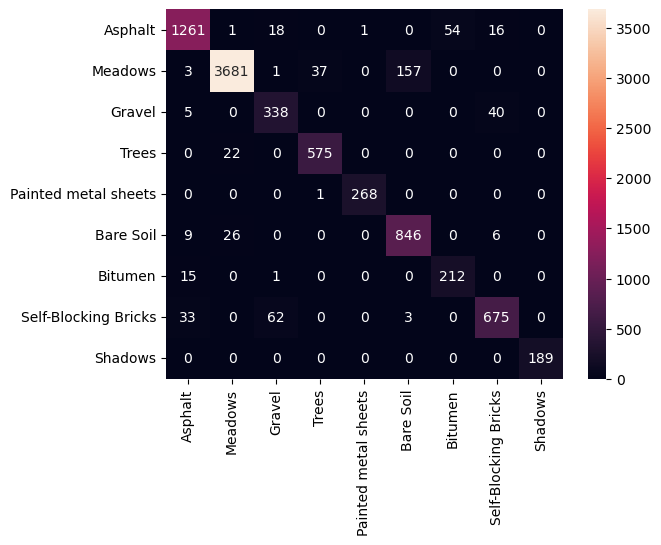

In [416]:
#confusion matrix

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(np.add(best_model.predict(X_test), 1), np.add(np.argmax(y_test, 1), 1))

classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets',
            'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows']

df_cm = pd.DataFrame(mat, index = classes, columns = classes)


sns.heatmap(df_cm, annot=True, fmt='d')



In [418]:
#confusion matrix on test set

print(classification_report(pred, np.argmax(y_test, 1), target_names = classes.append('Background')))


              precision    recall  f1-score   support

           1       0.95      0.93      0.94      1344
           2       0.99      0.95      0.97      3889
           3       0.81      0.87      0.84       392
           4       0.93      0.97      0.95       589
           5       1.00      1.00      1.00       269
           6       0.83      0.94      0.88       885
           7       0.80      0.91      0.85       232
           8       0.91      0.88      0.89       767
           9       1.00      1.00      1.00       189

    accuracy                           0.94      8556
   macro avg       0.91      0.94      0.92      8556
weighted avg       0.94      0.94      0.94      8556

